In [1]:
## dcmcontrol_ser_tk.ipynb
# dcm control GUI using virtual serial port 
# dew.ninja  Apr 2024
# use queue

### tkinter development

In [1]:
# class implementation for dcmcontrol_ser_tk GUI
import tkinter as tk
from tkinter import *
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import serial
import queue 
import time

0.01,0,0,200,1,1,300,1.0,500,0.1,1,1,50
Cleaning up.. 


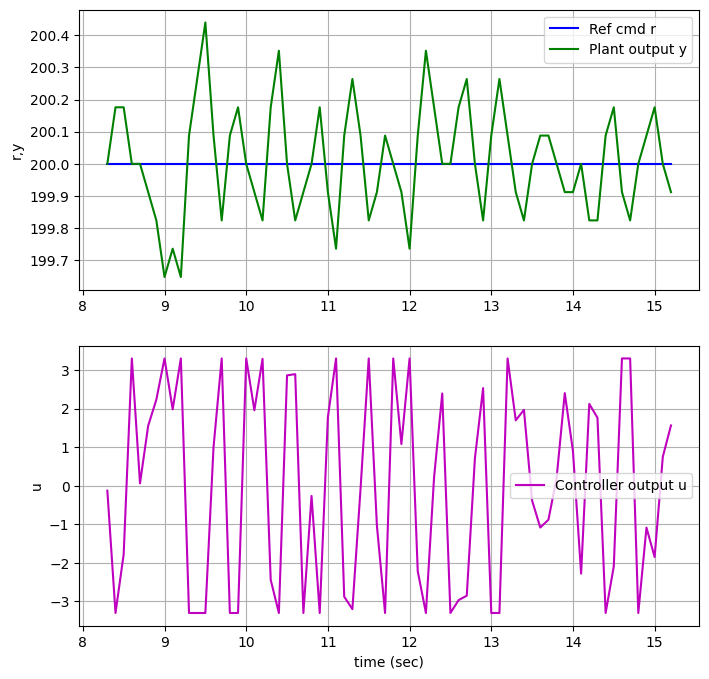

In [3]:
class dcmControllerSerial:

    def __init__(self, root):
        
        screen_width = 1100
        screen_height = 1000
        self.TFont1 = ("Consolas",10)
        self.TFont2 = ("Consolas",12)
        
        root.title("DCM Controller Serial")
        root.protocol("WM_DELETE_WINDOW", self.on_close)
        root.geometry(str(screen_width)+'x'+str(screen_height))
        mainframe = ttk.Frame(root, padding="3 3 12 12")
        mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        root.columnconfigure(0, weight=1)
        root.rowconfigure(0, weight=1)
        cvrowspan = 6  # canvas row and column span
        cvcolspan = 3
        self.vspon = True  # flag whether to use VSP or not
        
        # queue used for serial data buffer. May not need this
        #dataq = queue.Queue()
        
        #---- serial communication setup ------------
        if self.vspon:
            self.ser = serial.Serial('COM8', 115200, timeout=1)
            self.ser.reset_input_buffer() # flush all data that you don't wanna read
            self.ser.reset_output_buffer()
        self.msgline = []
        self.msglines = []
        # -----------------------------------------------------------
        
        # string parameters corresponding to real parmeter values
        self.t_txt = StringVar()
        self.plantsim_txt = StringVar()
        self.datasize_txt = StringVar()
        self.capture_txt = StringVar()
        self.feedback_txt = StringVar()
        self.controller_txt = StringVar()
        self.autotune_txt = StringVar()
        self.lsid_txt = StringVar()
        self.streaming_txt = StringVar()
        self.kp_txt = StringVar()
        self.ki_txt = StringVar()
        self.kd_txt = StringVar()
        self.kt_txt = StringVar()
        self.wp_txt = StringVar()
        self.wd_txt = StringVar()
        self.N_txt = StringVar()  
        self.datasize_txt = StringVar()
        self.winsize_txt = StringVar()
        
        ttk.Label(mainframe, text="dew.ninja 2024", font=self.TFont2, foreground="blue").grid(column=3,row=8)
        # ---------------- update parameters to current value -------------
        ttk.Button(mainframe, text="Update", command=self.dbupdate).grid(column=0, row=cvrowspan+5, sticky=W)
        # -----------------r,y,u display --------------------------------
        ryuframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        ryuframe.grid(column=0,row=cvrowspan+1)
        ttk.Label(ryuframe, text="r ", font=self.TFont1).grid(column=0, row=0, sticky=W)
        ttk.Label(ryuframe, text="y ",font=self.TFont1).grid(column=0, row=1, sticky=W)
        ttk.Label(ryuframe, text="u ",font=self.TFont1).grid(column=0, row=2, sticky=W)
        
        self.r_txt = StringVar()
        r_entry = ttk.Entry(ryuframe,width=7, textvariable=self.r_txt)
        r_entry.grid(column=1, row=0, sticky=(W, E))
        ttk.Button(ryuframe, text="Set", command=self.send_r).grid(column=2, row=0, sticky=W)

        self.y_txt = StringVar()
        self.u_txt = StringVar()
        ttk.Label(ryuframe, font=self.TFont1, foreground='blue',
                  textvariable=self.y_txt).grid(column=1, row=1, sticky=(W, E))
        ttk.Label(ryuframe, font=self.TFont1, foreground='green',
                  textvariable=self.u_txt).grid(column=1, row=2, sticky=(W, E))

        # --------------- send arbitrary command ------------------------
        cmdframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        cmdframe.grid(column=0,row=cvrowspan+2)
        
        ttk.Label(cmdframe, text="Command", font=self.TFont1,foreground='red').grid(column=0, row=0, sticky=W)        
        
        self.cmd_txt = StringVar()
        cmd_entry = ttk.Entry(cmdframe,width=20, textvariable=self.cmd_txt)
        cmd_entry.grid(column=0, row=1, sticky=(W, E))
        ttk.Button(cmdframe, text="Send", command=self.send_cmd).grid(column=2, row=1, sticky=W)
        
        
        # ------------ feedback group ----------------
        fbframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        fbframe.grid(column=cvcolspan,row=0)        
        
        ttk.Label(fbframe, text="Feedback", font=self.TFont1,foreground='red').grid(column=0, row=0, sticky=W)        
        self.olrb = (ttk.Radiobutton(fbframe,text="Open-loop", variable=self.feedback_txt,
                                     value="0",command=self.send_cmd_fbopen).
                                     grid(column=0, row=1, sticky=W))
        self.clrb = (ttk.Radiobutton(fbframe, text="Closed-loop", variable=self.feedback_txt,
                                     value="1",command=self.send_cmd_fbclosed).
                                     grid(column=0, row=2, sticky=W))

        # ---------controller group ---------------------
        ctlframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        ctlframe.grid(column=cvcolspan,row=1)        
        
        ttk.Label(ctlframe, text="Controller", font=self.TFont1,foreground='magenta').grid(column=0, row=0, sticky=W)        
        self.pidrb = (ttk.Radiobutton(ctlframe,text="PID", variable=self.controller_txt,
                                      value="0",command=self.send_cmd_pid_control).grid(column=0, 
                                                                            row=1, sticky=W))
        self.ccrb = (ttk.Radiobutton(ctlframe, text="Custom", variable=self.controller_txt,
                                     value="1",command=self.send_cmd_cc_control).grid(column=0,
                                                                            row=2, sticky=W))
        self.sfbrb = (ttk.Radiobutton(ctlframe, text="SFBI", variable=self.controller_txt,
                                     value="2",command=self.send_cmd_sfbi_control).grid(column=0, 
                                                                            row=3, sticky=W))
        
        # ---------------- PID group -------------------------
        pidframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        pidframe.grid(column=cvcolspan,row=2)                
        ttk.Label(pidframe, text="PID", font=self.TFont1,foreground='green').grid(column=0, row=0, sticky=W)        
        self.atbutton = (ttk.Button(pidframe, text="Autotune", command=self.send_cmd_at).grid(
                        column=1, row=0, sticky=W))
        # Kp scale
        ttk.Label(pidframe, text="Kp ",font=self.TFont1).grid(column=0, row=1, sticky=W)
        # note that tk scale is used instead of ttk here
        self.kpscale =(tk.Scale(pidframe, orient=HORIZONTAL,length=100, from_=0.1, to=1000.0,
                        resolution=0.1, troughcolor="blue",variable=self.kp_txt))        
        self.kpscale.grid(column=1, row=1)
        # this is how the slider is executed only on release!
        self.kpscale.bind("<ButtonRelease-1>", self.send_cmd_kp)

        # Ki scale
        ttk.Label(pidframe, text="Ki ",font=self.TFont1).grid(column=0, row=2, sticky=W)
        self.kiscale =(tk.Scale(pidframe, orient=HORIZONTAL,length=100, from_=0.1, to=1000.0,
                        resolution=0.1,troughcolor="red",variable=self.ki_txt))
        self.kiscale.grid(column=1, row=2)
        self.kiscale.bind("<ButtonRelease-1>", self.send_cmd_ki)

        # Kd scale
        ttk.Label(pidframe, text="Kd ",font=self.TFont1).grid(column=0, row=3, sticky=W)
        self.kdscale =(tk.Scale(pidframe, orient=HORIZONTAL,length=100, from_=0.1, to=1000.0,
                        resolution=0.1,troughcolor="yellow",variable=self.kd_txt))
        self.kdscale.grid(column=1, row=3)
        self.kdscale.bind("<ButtonRelease-1>", self.send_cmd_kd)

        # Kt scale
        ttk.Label(pidframe, text="Kt ",font=self.TFont1).grid(column=0, row=4, sticky=W)
        self.ktscale =(tk.Scale(pidframe, orient=HORIZONTAL,length=100, from_=0.0, to=5.0,
                        resolution=0.1,troughcolor="white",variable=self.kt_txt))
        self.ktscale.grid(column=1, row=4)
        self.ktscale.bind("<ButtonRelease-1>", self.send_cmd_kt)
        
        # Wp scale
        ttk.Label(pidframe, text="Wp ",font=self.TFont1).grid(column=0, row=5, sticky=W)
        self.wpscale =(tk.Scale(pidframe, orient=HORIZONTAL,length=100, from_=0.0, to=1.0,
                        resolution=0.1,troughcolor="magenta",variable=self.wp_txt))
        self.wpscale.grid(column=1, row=5)
        self.wpscale.bind("<ButtonRelease-1>", self.send_cmd_wp)
        
        # Wd scale
        ttk.Label(pidframe, text="Wd ",font=self.TFont1).grid(column=0, row=6, sticky=W)
        self.wdscale =(tk.Scale(pidframe, orient=HORIZONTAL,length=100, from_=0.0, to=1.0,
                        resolution=0.1,troughcolor="cyan",variable=self.wd_txt))
        self.wdscale.grid(column=1, row=6)
        self.wdscale.bind("<ButtonRelease-1>", self.send_cmd_wd)

        # N scale
        ttk.Label(pidframe, text="N ",font=self.TFont1).grid(column=0, row=7, sticky=W)
        self.nscale =(tk.Scale(pidframe, orient=HORIZONTAL,length=100, from_=2, to=200,
                        resolution=1,troughcolor="black",variable=self.N_txt))
        self.nscale.grid(column=1, row=7)
        self.nscale.bind("<ButtonRelease-1>", self.send_cmd_N)

        # ---------------- Plotmode group -------------------------
        plotmodeframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        plotmodeframe.grid(column=cvcolspan,row=3)                
        ttk.Label(plotmodeframe, text="Plot control", 
                  font=self.TFont1,foreground='magenta').grid(column=0, row=0, sticky=W)        
        self.snapshotrb = (ttk.Radiobutton(plotmodeframe,text="Pause", variable=self.streaming_txt,
                                      value="0",command=self.send_cmd_streaming).grid(column=0, 
                                                                            row=1, sticky=W))
        self.streamingrb = (ttk.Radiobutton(plotmodeframe, text="Streaming", variable=self.streaming_txt,
                                     value="1",command=self.send_cmd_streaming).grid(column=0,
                                                                            row=2, sticky=W))
        # windowsize scale. sliding window width in streaming mode
        ttk.Label(plotmodeframe, text="Window size ",font=self.TFont1).grid(column=0, row=3, sticky=W)
        self.winsizescale =(tk.Scale(plotmodeframe, orient=HORIZONTAL,length=100, 
                            from_=0, to=1000,resolution=10,troughcolor="green",
                                variable=self.winsize_txt))
        self.winsizescale.grid(column=1, row=3)
        self.winsizescale.bind("<ButtonRelease-1>", self.adjust_winsize)
        
        
        ttk.Button(plotmodeframe, text="Flush input", command=self.flush_input).grid(column=0, 
                                                                        row=4, sticky=W)
        ttk.Button(plotmodeframe, text="Flush output", command=self.flush_output).grid(column=1, 
                                                                        row=4, sticky=W)
        self.usevsp = BooleanVar()
        self.usevsp.set(str(self.vspon))
        ttk.Checkbutton(plotmodeframe, text="use VSP",variable=self.usevsp,command=self.use_vsp).grid(column=0, 
                                                                row=5, sticky=W)
        
        
        # ---------------- r,y,u time series plot --------------------------
        self.time_step = 0.0
        self.time_vec = []
        self.r_vec = []
        self.y_vec = []
        self.u_vec = []
       
        self.fig, self.axes  = plt.subplots(2,1,figsize=(8,8))
        self.ax1, self.ax2 = self.fig.get_axes()
        self.canvas = FigureCanvasTkAgg(self.fig, master=mainframe)
        self.canvas.get_tk_widget().grid(row=0,column=0, rowspan=cvrowspan, columnspan=cvcolspan, sticky=W)
        self.an1 = FuncAnimation(self.fig, self.animate, interval=10,cache_frame_data=False) # plot every 50 ms
        self.an1.pause()
        

        for child in mainframe.winfo_children(): 
            child.grid_configure(padx=5, pady=5)
        
#  change IoT to virtual serial communication
#         self.Client_ID = "6740ee15-1cf4-405d-883c-1edcd8a3d350"
#         self.User = "ArJUFe3L6jX1ibHJ785B36p4Wnttmdvt"
#         self.Password = "M-TXJt6C2JvaSIe)uks05961lHAIlvzT"    
#         self.broker = "broker.netpie.io"
#         self.port = 1883     
#         self.mqtt_connect()
        
        # controller parameter list. Values will be updated by ESP32
        self.r = 0.5
        self.y = 0.5
        self.u = 0.5
        self.t = 0.05
        self.plantsim = 0
        self.datasize = 200
        self.capture = 0
        self.feedback = 1
        self.controller = 0
        self.autotune = 0
        self.lsid = 0
        self.kp = 300.0
        self.ki = 1.0
        self.kd = 500.0
        self.kt = 0
        self.wp = 1
        self.wd = 1
        self.N = 50
        self.streaming = 0  # 0 : pause, 1 : streaming
        self.datasize = 200
        self.winsize = 200
        
        # set default values
        self.datasize_txt.set(str(self.datasize))
        self.capture_txt.set(str(self.capture))
        self.feedback_txt.set(str(self.feedback))
        self.controller_txt.set(str(self.controller))
        self.autotune_txt.set(str(self.autotune))
        self.lsid_txt.set(str(self.lsid))
        self.streaming_txt.set(str(self.streaming))
        self.kp_txt.set(str(self.kp))
        self.ki_txt.set(str(self.ki))
        self.kd_txt.set(str(self.kd))
        self.kt_txt.set(str(self.kt))
        self.wp_txt.set(str(self.wp))
        self.wd_txt.set(str(self.wd))
        self.N_txt.set(str(self.N))
        self.winsize_txt.set(str(self.winsize))       
        # flags
        self.show_r = True
        

#     def mqtt_connect(self):
#         print("Connecting to mqtt broker")
#         try:
#             self.client = mqtt.Client(client_id=self.Client_ID,
#                          transport='tcp',
#                          protocol=mqtt.MQTTv311,
#                          clean_session=True)
#             self.client.username_pw_set(self.User,self.Password)
#             self.client.connect(self.broker, port=self.port, keepalive=60)
#             self.client.subscribe("@msg/update")
#             self.client.subscribe("@msg/shadowdata")
#             self.client.on_message = self.on_message
#             self.client.loop_start()
#         except:
#             print("Problem connecting to mqtt broker")

#     def on_message(self,client, userdata, message):
#         self.rcvd_msg = str(message.payload.decode("utf-8"))
#         self.rcvd_topic = message.topic
#         #print("message received ", self.rcvd_msg)
#         #print("message topic=",message.topic)
#         if self.rcvd_topic == "@msg/shadowdata":
#             ryu_data = self.rcvd_msg.split(',')
#             self.r = float(ryu_data[0])
#             self.y = float(ryu_data[1])
#             self.u = float(ryu_data[2])
#             print("r = "+str(self.r)+", y = "+str(self.y)+", u = "+str(self.u))
#             if self.show_r:
#                 self.r_txt.set(str(round(self.r,2)))
#                 self.show_r = False
#             self.y_txt.set(str(round(self.y,3)))
#             self.u_txt.set(str(round(self.u,3)))
#             self.time_step += 1

#         if self.rcvd_topic == "@msg/update":
#             parm_data = self.rcvd_msg.split(',')
#             # strings for GUI update
#             self.t_txt.set(parm_data[0])
#             self.plantsim_txt.set(parm_data[1]) 
#             self.datasize_txt.set(parm_data[2])
#             self.capture_txt.set(parm_data[3]) 
#             self.feedback_txt.set(parm_data[4]) 
#             self.controller_txt.set(parm_data[5]) 
#             self.autotune_txt.set(parm_data[6])
#             self.lsid_txt.set(parm_data[7])
#             self.kp_txt.set(parm_data[8])
#             self.ki_txt.set(parm_data[9]) 
#             self.kd_txt.set(parm_data[10]) 
#             self.kt_txt.set(parm_data[11])
#             self.wp_txt.set(parm_data[12]) 
#             self.wd_txt.set(parm_data[13]) 
#             self.N_txt.set(parm_data[14])
            
#             # update parameters
#             self.t = float(parm_data[0])
#             self.plantsim = int(parm_data[1]) 
#             self.datasize = int(parm_data[2]) 
#             self.capture = int(parm_data[3]) 
#             self.feedback = int(parm_data[4]) 
#             self.controller = int(parm_data[5]) 
#             self.autotune = int(parm_data[6]) 
#             self.lsid = int(parm_data[7]) 
#             self.kp = float(parm_data[8]) 
#             self.ki = float(parm_data[9]) 
#             self.kd = float(parm_data[10]) 
#             self.kt = float(parm_data[11]) 
#             self.wp = float(parm_data[12]) 
#             self.wd = float(parm_data[13]) 
#             self.N = float(parm_data[14]) 

            
    def animate(self,i):
        if self.vspon:
            # read data from serial buffer. 
            if self.streaming:  
                self.msgline = self.ser.readline()
                datastr = self.msgline.decode().strip()
                if '$' not in datastr:  # not contaminated by system command/ response 
                    plot_data = datastr.split(',')
                    # print(plot_data)
                    if len(plot_data)==4:
                        self.time_step = float(plot_data[0])
                        self.r = float(plot_data[1])
                        self.y = float(plot_data[2])
                        self.u = float(plot_data[3]) 

                        self.y_txt.set(plot_data[2])
                        self.u_txt.set(plot_data[3])

                        self.time_vec.append(self.time_step)
                        self.r_vec.append(self.r)
                        self.y_vec.append(self.y)
                        self.u_vec.append(self.u)
#             else:  # snapshot mode
#               This approach does not work
#                 data = []  
#                 finished = False
#                 while not finished:
#                     datalines = self.ser.readlines()
#                     data += datalines
#                     finished = self.isfinished(datalines)
#                 datastr = self.extract_and_clean(data)                
#                 print(datastr)
#                 exec(datastr)
#                 self.time_vec = datamat[:,0]
#                 self.r_vec = datamat[:,1]
#                 self.y_vec = datamat[:,2]
#                 self.u_vec = datamat[:,3] 
#                 ulimvec = datamat[:,4]
    #             self.msglines = self.ser.readlines()
    #             for line in self.msglines:
    #                 print("receiving data")
    #                 datastr = line.decode().strip()
    #                 if '$' not in datastr:  # not contaminated by system command/ response
    #                     plot_data = datastr.split(',')
    #                     self.time_step = float(plot_data[0])
    #                     self.r = float(plot_data[1])
    #                     self.y = float(plot_data[2])
    #                     self.u = float(plot_data[3])

    #                     self.time_vec.append(self.time_step)
    #                     self.r_vec.append(self.r)
    #                     self.y_vec.append(self.y)
    #                     self.u_vec.append(self.u)

            if self.streaming and (len(self.time_vec)>self.winsize): # discard old data
                self.time_vec = self.time_vec[1:]
                self.r_vec = self.r_vec[1:]
                self.y_vec = self.y_vec[1:]
                self.u_vec = self.u_vec[1:]

            self.ax1.cla()
            self.ax2.cla()

            self.ax1.plot(self.time_vec, self.r_vec,'b-',self.time_vec,self.y_vec,'g-')
            self.ax2.plot(self.time_vec, self.u_vec,'m-')
            self.ax1.grid()
            self.ax2.grid()
            self.ax1.legend(['Ref cmd r','Plant output y'])

            self.ax1.set_ylabel("r,y")
            self.ax2.set_ylabel("u")
            self.ax2.legend(['Controller output u'])
            self.ax2.set_xlabel("time (sec)")
            # print("Animating")
            if not self.streaming:
                self.an1.pause()
            
    def dbupdate(self, *args):
        if self.vspon:
            cmd_txt = "$update\r\n"
            self.ser.reset_input_buffer()
            self.ser.reset_output_buffer()
            self.ser.write(cmd_txt.encode('utf-8'))
            time.sleep(0.5)
            self.msgline = self.ser.readline() # echo of command.        
            time.sleep(0.5)
            self.msgline = self.ser.readline()
            self.msgline = self.msgline[1:].decode().strip()
            print(self.msgline)
            parm_data = self.msgline.split(',')
            self.t_txt.set(parm_data[0])
            self.streaming_txt.set(parm_data[1])
            self.capture_txt.set(parm_data[2])
            self.datasize_txt.set(parm_data[3])
            self.feedback_txt.set(parm_data[4])
            self.controller_txt.set(parm_data[5])
            self.kp_txt.set(parm_data[6])
            self.ki_txt.set(parm_data[7])
            self.kd_txt.set(parm_data[8])
            self.kt_txt.set(parm_data[9])
            self.wp_txt.set(parm_data[10])
            self.wd_txt.set(parm_data[11])
            self.N_txt.set(parm_data[12])

            self.t = float(parm_data[0])
            self.streaming = int(parm_data[1])
            self.capture = int(parm_data[2])
            self.datasize = int(parm_data[3])
            self.feedback = int(parm_data[4])
            self.controller = int(parm_data[5])
            self.kp = float(parm_data[6])
            self.ki = float(parm_data[7])
            self.kd = float(parm_data[8])
            self.kt = float(parm_data[9])
            self.wp = float(parm_data[10])
            self.wd = float(parm_data[11])
            self.N = float(parm_data[12])
        

    def send_cmd(self, *args):
        if self.vspon:
            cmd_txt = "$"+self.cmd_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
#         self.client.publish("@msg/cmd",cmd_txt)
    def send_r(self, *args):
        if self.vspon:                
            cmd_txt = "$r="+self.r_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
            if not self.streaming:
                self.an1.resume()
        
        
#         self.client.publish("@msg/cmd",cmd_txt)
    def send_cmd_at(self, *args):
        if self.vspon:
            cmd_txt = "$autotune"+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_fbopen(self, *args):
        if self.vspon:
            cmd_txt = "$feedback=0"+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_fbclosed(self, *args):
        if self.vspon:
            cmd_txt = "$feedback=1"+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_pid_control(self, *args):
        if self.vspon:                     
            cmd_txt = "$controller=0"+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_cc_control(self, *args):
        if self.vspon:                               
            cmd_txt = "$controller=1"+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_sfbi_control(self, *args):
        if self.vspon:  
            cmd_txt = "$controller=2"+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_kp(self, *args):
        if self.vspon:                               
            cmd_txt = "$kp="+self.kp_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_ki(self, *args):
        if self.vspon:                               
            cmd_txt = "$ki="+self.ki_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_kd(self, *args):
        if self.vspon:                               
            cmd_txt = "$kd="+self.kd_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_kt(self, *args):
        if self.vspon:                               
            cmd_txt = "$kt="+self.kt_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_wp(self, *args):
        if self.vspon:                               
            cmd_txt = "$wp="+self.wp_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_wd(self, *args):
        if self.vspon:                               
            cmd_txt = "$wd="+self.wd_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
    def send_cmd_N(self, *args):
        if self.vspon:                               
            cmd_txt = "$n="+self.N_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
#     def send_cmd_datasize(self, *args):
#         if self.vspon:                               
#             cmd_txt = "$datasize="+self.datasize_txt.get()+"\r\n"
#             self.ser.write(cmd_txt.encode('utf-8'))
    def adjust_winsize(self, *args):
        self.winsize = int(self.winsize_txt.get())
        #print(self.winsize)
        # reinitialize plot vectors
        self.time_vec=[]
        self.r_vec=[]
        self.y_vec=[]
        self.u_vec=[]           
        
    def flush_input(self, *args):   
        if self.vspon:                               
            self.ser.reset_input_buffer()
    def flush_output(self, *args): 
        if self.vspon:                               
            self.ser.reset_output_buffer()
    def use_vsp(self, *args): 
        self.vspon = self.usevsp.get()
        if self.vspon:                               
            self.ser = serial.Serial('COM8', 115200, timeout=1)
            self.ser.reset_input_buffer() # flush all data that you don't wanna read
            self.ser.reset_output_buffer()
        else:
            self.ser.close()
            
    def send_cmd_streaming(self, *args):
        if self.vspon: 
            self.streaming = int(self.streaming_txt.get())
#             if self.streaming:
#                 cmd_txt = "$capture=0\r\n"
#                 self.ser.write(cmd_txt.encode('utf-8'))    
#                 time.sleep(1)
            
            cmd_txt = "$streaming="+self.streaming_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))    
            time.sleep(1)
#             if not self.streaming:
#                 cmd_txt = "$capture=1\r\n"
#                 self.ser.write(cmd_txt.encode('utf-8'))    
#                 time.sleep(1)
            
            self.ser.reset_input_buffer()
            self.ser.reset_output_buffer()


            if self.streaming:
                self.time_vec=[]
                self.r_vec=[]
                self.y_vec=[]
                self.u_vec=[]           
                self.an1.resume()
            else:
                self.an1.pause()

#   this approach does not work well in GUI environment                 
#     def isfinished(self,readbuffer):  # check if end of datamat reached. Use in snapshot mode
#         finish_flag = False
#         if readbuffer == []:
#             finish_flag = True
#         for line in readbuffer:
#             if b'])' in line:
#                 finish_flag = True
#         return finish_flag                

#     def extract_and_clean(self,datalist):
#         datastr = ''
#         for line in datalist:
#             datastr += line.decode().strip()
#         idx_start = datastr.rfind("datamat")
#         idx_end = datastr.rfind("])")
#         datastr = datastr[idx_start:idx_end+2]
#         return datastr


    def on_close(self):
        print("Cleaning up.. ")
#         self.client.loop_stop()
#         self.client.disconnect()
        if self.vspon:                               
            self.ser.close()
        root.destroy()

root = Tk()
dcmControllerSerial(root)
root.mainloop()
    